In [47]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from math import fabs, sqrt, log, exp

In [48]:
def bound(N, loss, L):
    '''
    Calculate annoying parameters to estimate rho
    '''

    R1 = 0.0
    R2 = 0.0
    Sp1 = 0.0
    Sm1 = 0.0
    Sp2 = 0.0
    Sm2 = 0.0
    for i in range(N + 1):
        # compute plus
        alpha0 = L ** i
        alpha1 = i * L ** (i - 1)
        alpha2 = i * (i - 1) * L ** (i - 2)
        R1 += alpha0
        Sp1 += alpha1
        Sp2 += alpha2
        # compute minus
        beta0 = 0.0
        beta1 = 0.0
        beta2 = 0.0
        for k in range(i, N + 1):
            # compute forward difference
            delta = 0.0
            for j in range(k + 1):
                delta += comb_dict[k][j] * (-1) ** (k - j) * loss(j / N)
            # compute coefficient
            beta0 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * fabs(delta) / (2 ** k) / (L ** i)
            beta1 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * fabs(delta) / (2 ** k) / (L ** (i + 1))
            beta2 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * (k - i - 1) * fabs(delta) / (2 ** k) / (
                        L ** (i + 2))
        R2 += beta0
        Sm1 += beta1
        Sm2 += beta2

    gamma = max((2 * R1 + R2) * Sp2 + Sp1 ** 2, (2 * R2 + R1) * Sm2 + Sm1 ** 2) / (N + 1)

    return R1, R2, gamma

In [49]:
def bern_loss_func(name, L):
    
    '''
    Define loss function

    input:
        name - name of loss funtion
        L - bound for prod

    output:
        loss - loss function
    '''
    
    if name == 'hinge':
        loss = lambda x: max(0, 1 + L - 2 * L * x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(L - 2 * L * x))
    else:
        print('Wrong loss function!')

    return loss

In [74]:
def pos(i,prod,L):
    '''
    Compute positive function and gradient information
    
    input:
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    plus = L/2+prod
    fpt = plus**i
    gfpt = fpt*i/plus # no xt yet!
    
    wasted = time.time() - start
    
    return fpt,gfpt,wasted              

In [51]:
def comb(n, k):
    '''
    Compute combination
    
    input:
        n - total number
        k - number of chosen
    
    output:
        c - number of combination
    '''
    return factorial(n) / factorial(k) / factorial(n - k)

In [52]:
comb_dict = {0:{0:1},1:{0:1,1:1},2:{0:1,1:2,2:1},3:{0:1,1:3,2:3,3:1},4:{0:1,1:4,2:6,3:4,4:1},
             5:{0:1,1:5,2:10,3:10,4:5,5:1},6:{0:1,1:6,2:15,3:20,4:15,5:6,6:1},
             7:{0:1,1:7,2:21,3:35,4:35,5:21,6:7,7:1},8:{0:1,1:8,2:28,3:56,4:70,5:56,6:28,7:8,8:1},
             9:{0:1,1:9,2:36,3:84,4:126,5:126,6:84,7:36,8:9,9:1},
             10:{0:1,1:10,2:45,3:120,4:210,5:252,6:210,7:120,8:45,9:10,10:1}}

In [73]:
def neg(N,loss,i,prod,L):
    '''
    Compute negative function and gradient information
    
    input:
        loss - loss function
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    minus = L/2-prod
    fnt = 0.0
    gfnt = 0.0
    for k in range(i,N+1):
        # compute forward difference
        delta = 0.0
        for j in range(k+1):
            delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            
        # compute coefficient
        beta = (comb_dict[N][k]*comb_dict[k][i]*(N+1)*delta/((2*L)**k))*(minus**(k-i))
        # compute function value
        fnt += beta
        # compute gradient
        gfnt += beta*(k-i)/minus  # no xt yet!
    
    wasted = time.time() - start
    return fnt,gfnt,wasted

In [54]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [55]:
def proj(x,R):
    '''
    Projection
    
    input:
        x - 
        R - radius
        
    output:
        proj - projected 
    '''
    norm = np.linalg.norm(x)
    if norm > R:
        x = x/norm*R
    return x

In [56]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [57]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [58]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [59]:
def prox(N, eta, loss, index, X, Y, L, R1, R2, gamma, wj, aj, bj, alphaj, bwt):
    '''
    perform proximal guided gradient descent when receive an sample

    input:
        N - 
        eta - step size
        loss - loss function
        index -
        X - sample features
        Y - sample labels
        L -
        R1 -
        R2 -
        gamma -
        wj -
        aj -
        bj -
        alphaj -
        bwt -

    output:
        wj - w at jth step
        aj -
        bj -
        alphaj -
        wasted - time wasted on computing
    '''

    prod = np.dot(wj, X[index])
    wasted = 0.0
    fpt = np.zeros(N + 1)
    gfpt = np.zeros(N + 1)
    fnt = np.zeros(N + 1)
    gfnt = np.zeros(N + 1)
    gradwt = 0.0
    
    for i in range(N + 1):
        fpt[i], gfpt[i], _ = pos(i, prod, L)
        wasted += _
        fnt[i], gfnt[i], _ = neg(N, loss, i, prod, L)
        wasted += _
        gradwt += w_grad(gfpt[i], gfnt[i], Y[index], aj[i], bj[i], alphaj[i])  # accumulate i
        gradat = a_grad(fpt[i], Y[index], aj[i])
        gradbt = b_grad(fnt[i], Y[index], bj[i])
        gradalphat = alpha_grad(fpt[i], fnt[i], Y[index], alphaj[i])

        aj[i] = aj[i] - eta * gradat / (2 * (N + 1))
        bj[i] = bj[i] - eta * gradbt / (2 * (N + 1))
        alphaj[i] = alphaj[i] + eta * gradalphat / (2 * (N + 1))

    wj = wj - eta * (gradwt * X[index] * Y[index] / (2 * (N + 1)) + gamma * (wj - bwt))

    wj = proj(wj, L / 2)
    aj = proj(aj, R1)
    bj = proj(bj, R2)
    alphaj = proj(alphaj, R1 + R2)

    return wj, aj, bj, alphaj, wasted

In [60]:
def PGSPD(N, t, loss, passing_list, X, Y, L, R1, R2, gamma, c, bwt, bat, bbt, balphat):

    '''
    Proximally Guided Stochastic Primal Dual Inner loop

    input:
        N - 
        t - iteration at t
        loss - loss function
        passing_list
        X -
        Y -
        L -
        R1 -
        R2 -
        gamma -
        c -
        bwt - last outer loop w
        bat - last outer loop a
        bbt - last outer loop b
        balphat - last outer loop alpha

    output:
        bwt - next outer loop w
        bat - next outer loop a
        bbt - next outer loop b
        balphat - next outer loop alpha
        wasted - time wasted on computing
    '''
    
    wasted = 0.0
    # initialize inner loop variables
    Wt = bwt + 0.0
    At = bat + 0.0
    Bt = bbt + 0.0
    ALPHAt = balphat + 0.0

    BWt = 0.0
    BAt = 0.0
    BBt = 0.0
    BALPHAt = 0.0

    ETAt = c / sqrt(t) / gamma
    
    

    # inner loop update at j
    for j in range(t):
        # update inner loop variables
        Wt, At, Bt, ALPHAt, _ = prox(N, ETAt, loss, passing_list[j], X, Y, L, R1, R2, gamma, Wt, At, Bt, ALPHAt, bwt)
        wasted += _
        
        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt

    # update outer loop variables
    bwt = BWt / t
    bat = BAt / t
    bbt = BBt / t
    balphat = BALPHAt / t

    return bwt, bat, bbt, balphat, wasted

In [76]:
def SAUC(T,name,N,L,c,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Stochastic AUC Optimization with General Loss

    input:
        T -
        name -
        N - Bernstein degree
        L - Bound for prod
        c - step size parameter
        Xtr - Training features
        Ytr - Training labels
        Xte - Testing features
        Yte - Testing labels
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''
    
    sum_time = 0.0
    
    wasted = 0.0 
    
    print('SAUC......')
    
    # get the dimension of what we are working with
    n, d = Xtr.shape

    WT = np.zeros(d)
    AT = np.zeros(N + 1)
    BT = np.zeros(N + 1)
    ALPHAT = np.zeros(N + 1)

    # define loss function
    loss = bern_loss_func(name, L)

    # compute gamma(get it done, bitch!)
    R1, R2, gamma = bound(N,loss,L)

    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    # Begin algorithm
    for t in range(1, T + 1):

        # Prepare the indices if you know what I mean
        prep_time = time.time()
        epoch = t // n
        begin = (t * (t - 1) // 2) % n
        end = (t * (t + 1) // 2) % n
        if epoch < 1:
            if begin < end:
                tr_list = [i for i in range(begin, end)]
            else:  # need to think better
                tr_list = [i for i in range(begin, n)] + [i for i in range(end)]
        else:
            if begin < end:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * (epoch - 1) + [i for i in range(end)]
            else:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * epoch + [i for i in range(end)]
        sum_time += time.time() - prep_time
        # Inner loop
        WT, AT, BT, ALPHAT, _ = PGSPD(N, t, loss, tr_list, Xtr, Ytr, L, R1, R2, gamma, c, WT, AT, BT, ALPHAT)
        wasted += _
        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time - sum_time - wasted)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, WT)))
            print('gamma: %.2f c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f/%.2f' % (gamma, c, t, roc_auc[-1], elapsed_time[-1],wasted))

            sum_time = 0.0
            # start_time = time.time()

    return elapsed_time, roc_auc

In [62]:
def loss_func(name):
    '''
    Define loss function

    input:
        name - name of loss function

    output:
        loss - loss function
    '''

    if name == 'hinge':
        loss = lambda x: max(0, 1 - x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(-x))
    else:
        print('Wrong loss function!')

    return loss

In [63]:
def reservior(Bt,xt,N,M):
    '''
    Reservior Sampling

    input:
        Bt - current buffer
        xt - a training instance
        N - the buffer size
        M - the number of instances received till trial t

    output:
        Bt - updated buffer
    '''

    L = len(Bt)
    if L < N:
        Bt.append(xt)
    else:
        z = np.random.binomial(1, p=N/M)
        if z == 1:
            ind = np.random.randint(L)
            Bt[ind] = xt

    return Bt

In [64]:
def seq(loss,wt,xt,yt,B,ct):
    '''
    Sequential update

    input:
        grad - gradient of loss function
        wt - the current classifier
        xt -
        yt -
        B - the buffer to be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    for i in range(L):
        prod = np.inner(wt,xt - B[i])
        norm = np.inner(xt - B[i],xt - B[i])
        tau = min(ct/2,loss(prod*yt)/norm)
        wt += tau*yt*(xt - B[i])

    return wt

In [65]:
def gra(wt,xt,yt,B,ct):
    '''
    gradient updating

    input:
        wt - the current classifier
        xt -
        yt -
        B - the bufferto be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    w = wt + 0.0
    for i in range(L):
        prod = np.inner(w,xt - B[i])
        if yt*prod <= 1:
            wt += ct*yt*(xt - B[i])/2

    return wt

In [66]:
def OAM(T,name,option,c,Np,Nn,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Online AUC Maximization

    input:
        T -
        name -
        option - update option
        c - penalty parameter
        Np - maximum buffer size of positive samples
        Nn - maximum buffer size of negative samples
        Xtr -
        Ytr -
        Xte -
        Yte -
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''

    print('OAM......')

    # get the dimension of what we are working with
    n, d = Xtr.shape

    # define loss function
    loss = loss_func(name)

    # initialize
    wt = np.zeros(d)
    Bpt = []
    Bnt = []
    Npt = 0
    Nnt = 0
    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    for t in range(1,T+1):
        if Ytr[t%n] == 1:
            Npt += 1
            ct = c*max(1,Nnt/Nn)
            Bpt = reservior(Bpt,Xtr[t%n],Np,Npt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bnt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bnt, ct)
            else:
                print('Wrong update option!')
                return
        else:
            Nnt += 1
            ct = c*max(1,Npt/Np)
            Bnt = reservior(Bnt,Xtr[t%n],Nn,Nnt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bpt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bpt, ct)
            else:
                print('Wrong update option!')
                return

        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, wt)))
            print('c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f' % (c, t, roc_auc[-1], elapsed_time[-1]))

            # start_time = time.time()

    return elapsed_time, roc_auc

In [67]:
# Read data from hdf5 file
dataset = 'mnist'
hf = h5py.File('/Users/yangzhenhuan/PycharmProjects/AUC/datasets/%s.h5' % (dataset), 'r')
FEATURES = hf['FEATURES'][:]
LABELS = hf['LABELS'][:]
hf.close()

In [86]:
# Define hyper parameters
N = 3
T = 500
folders = 2
stamp = 10
iteration = list(range(T//stamp))

In [80]:
# Define model parameters
L = [1]
C = [10]
Np = [100]
Nn = [100]

In [81]:
# Define losses and algorithms
NAME = ['logistic']
ALG = ['SAUC','OAM']
OPTION = ['sequential','gradient']

In [82]:
# Prepare training and testing
n = len(LABELS)
training = [i for i in range(n // 2)]
testing = [i for i in range(n // 2, n)]

In [87]:
# Prepare results
sauc_time,sauc_auc = SAUC(T,NAME[0],N,L[0],C[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp)
oam_time,oam_auc = OAM(T,NAME[0],OPTION[0],C[0],Np[0],Nn[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp)

SAUC......
gamma: 48.61 c: 10.00 iteration: 10 AUC: 0.511837 time eplapsed: 0.01/0.00
gamma: 48.61 c: 10.00 iteration: 20 AUC: 0.550063 time eplapsed: 0.05/0.01
gamma: 48.61 c: 10.00 iteration: 30 AUC: 0.595815 time eplapsed: 0.09/0.03
gamma: 48.61 c: 10.00 iteration: 40 AUC: 0.638711 time eplapsed: 0.15/0.06
gamma: 48.61 c: 10.00 iteration: 50 AUC: 0.671776 time eplapsed: 0.23/0.10
gamma: 48.61 c: 10.00 iteration: 60 AUC: 0.703791 time eplapsed: 0.36/0.16
gamma: 48.61 c: 10.00 iteration: 70 AUC: 0.733332 time eplapsed: 0.46/0.20
gamma: 48.61 c: 10.00 iteration: 80 AUC: 0.753681 time eplapsed: 0.68/0.30
gamma: 48.61 c: 10.00 iteration: 90 AUC: 0.777661 time eplapsed: 0.86/0.38
gamma: 48.61 c: 10.00 iteration: 100 AUC: 0.793801 time eplapsed: 1.05/0.46
gamma: 48.61 c: 10.00 iteration: 110 AUC: 0.808781 time eplapsed: 1.18/0.53
gamma: 48.61 c: 10.00 iteration: 120 AUC: 0.824192 time eplapsed: 1.34/0.62
gamma: 48.61 c: 10.00 iteration: 130 AUC: 0.836282 time eplapsed: 1.52/0.71
gamma: 48.

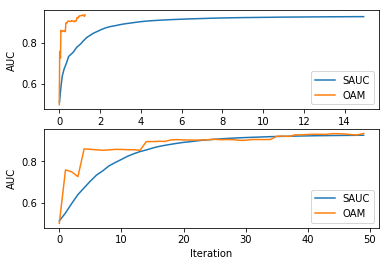

In [88]:
# Plot results
fig = plt.figure()  # create a figure object
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(sauc_time, sauc_auc, label='SAUC')
ax1.plot(oam_time, oam_auc, label='OAM')
ax1.set_xlabel('Time')
ax1.set_ylabel('AUC')
plt.legend()
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(iteration, sauc_auc, label='SAUC')
ax2.plot(iteration, oam_auc, label='OAM')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('AUC')
plt.legend()
plt.show()